# Quantization scheme

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import PercentFormatter

In [2]:
# Parameters for normal distribution
mu = 0
sigma = 0.5
param = 35648
x_float = np.random.normal(mu, sigma, param)

# Quantization parameters
M = 8 #<<<<<< CHANGE IT ! 
a_min  = - pow(2,M-1)
a_max  = pow(2,M-1) - 1

mean/mu = 0.002230098025989956 | std/sigma = 0.5006359224376663 


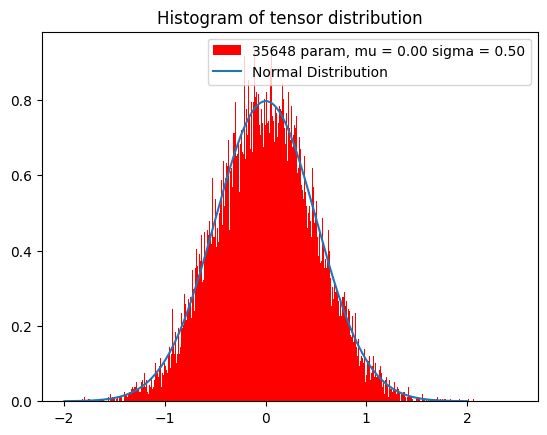

In [3]:
mu = np.mean(x_float)
sigma = np.std(x_float)

print("mean/mu = {} | std/sigma = {} ".format(mu, sigma))

plt.title(label="Histogram of tensor distribution")
plt.hist(x_float, bins=1000, density=True, label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])

# affichage de la courbe de la distribution normale pour comparaison
x = np.linspace(-2+mu,2+mu,1000)
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

plt.plot(x, y, label="Normal Distribution")

plt.legend()
plt.show()


Fxp quantization from float32 to fixed-point representation

M 8, s 0.03125


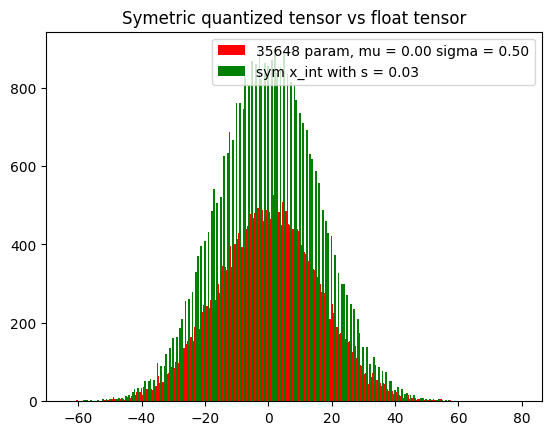

In [4]:

# Compute integer and fractional part resolution 

m = -(1 + np.floor(np.log2(np.max(np.abs(x)))))
n = -(M-1+m)

# Compute scale factor
s_fxp = 2**(n)

print("M {}, s {}".format(M, s_fxp))

x_int_fxp = np.clip(np.round(x_float/s_fxp), a_min, a_max)


plt.title(label="Symetric quantized tensor vs float tensor")
plt.hist(x_float/s_fxp, bins=pow(2,M), label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])
plt.hist(x_int_fxp, bins=pow(2,M),   label=(f"sym x_int with s = {s_fxp:.2f}"), color= ['green'])

plt.legend()
plt.show()

Sym Quantize from float32 to intX

127 2.4772355008284137
M 8, a_max 127, s 0.01950579134510562


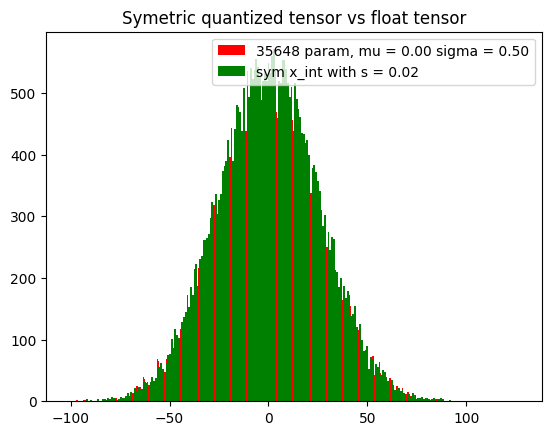

In [5]:
M = 8
a_max  = (pow(2,M-1)) - 1

print(a_max, np.max(np.abs(x_float)))

f_max  = np.max(np.abs(x_float))

s_sym = (f_max)/(a_max)

print("M {}, a_max {}, s {}".format(M, a_max, s_sym))

x_int = np.clip(np.round(x_float/s_sym), a_min, a_max)


plt.title(label="Symetric quantized tensor vs float tensor")
plt.hist(x_float/s_sym, bins=pow(2,M), label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])
plt.hist(x_int, bins=pow(2,M),   label=(f"sym x_int with s = {s_sym:.2f}"), color= ['green'])

plt.legend()
plt.show()

dequantize from intX to float32 for fxp and sym

35648 35648


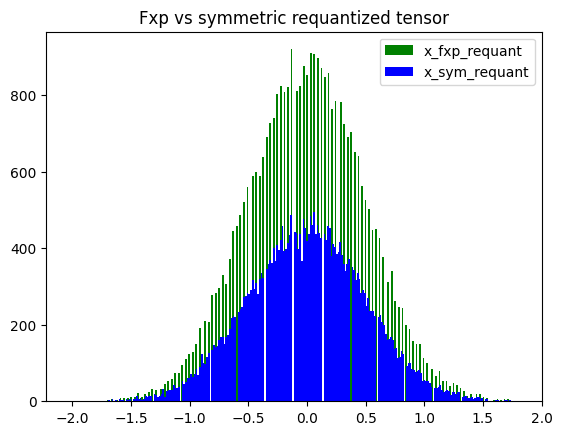

35648 35648


In [ ]:
x_sym_requant = s_sym*(x_int)
x_fxp_requant = s_fxp*(x_int_fxp)
print(len(x_fxp_requant), len(x_sym_requant))

plt.title(label="Fxp vs symmetric requantized tensor")
plt.hist(x_fxp_requant, bins=pow(2,M), label="x_fxp_requant", color= ['green'])
plt.hist(x_sym_requant, bins=pow(2,M), label="x_sym_requant", color= ['blue'])


plt.legend()
plt.show()

Show error for each scheme

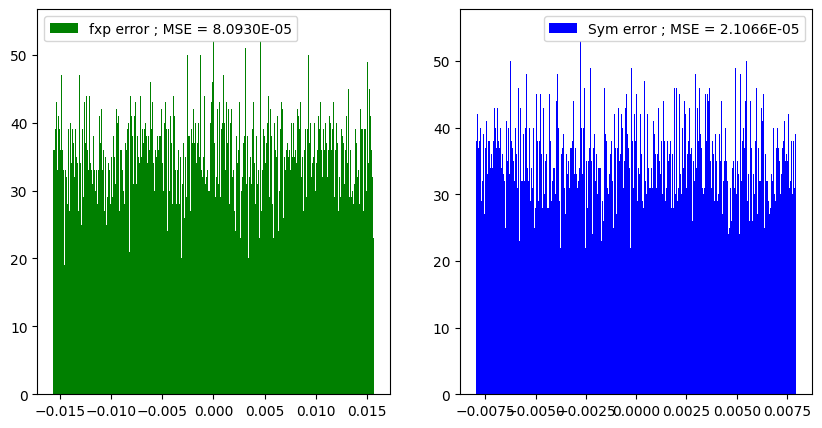

In [ ]:
MSE_sym = ((x_sym_requant - x_float)**2).mean()
MSE_fxp = ((x_fxp_requant - x_float)**2).mean()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(x_fxp_requant - x_float, label=f"fxp error ; MSE = {MSE_fxp:.4E}", bins=1000, color= ['green'])
axs[0].legend()
axs[1].hist(x_sym_requant - x_float, label=f"Sym error ; MSE = {MSE_sym:.4E}", bins=1000, color= ['blue'])
axs[1].legend()
plt.show()

Asym Quantize from float32 to intX

-3.0507846289555554 1.0939611918395138
M 8, f_min -3.05, f_max 1.09, a_min -128, a_max 127, s 0.01625390517958851, z 60


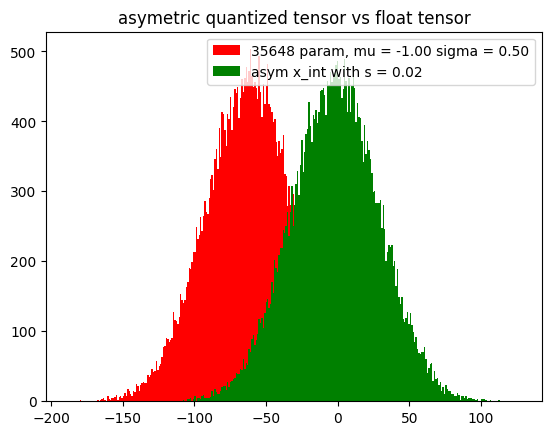

In [ ]:
M = M


f_max_asym  = np.max(x_float)
f_min_asym = np.min(x_float)

print(f_min_asym, f_max_asym)

s_asym = (f_max_asym - f_min_asym)/(a_max_asym - a_min_asym)

z_int = - round(f_min_asym/s_asym) + a_min_asym

print("M {}, f_min {:.03}, f_max {:.03}, a_min {}, a_max {}, s {}, z {}".format(M, f_min_asym, f_max_asym, a_min_asym, a_max_asym, s_asym, z_int))

x_int_asym = np.clip(np.round(x_float/s_asym)+z_int, a_min, a_max)


plt.title(label="asymetric quantized tensor vs float tensor")
plt.hist(x_float/s_asym, bins=pow(2,M), label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])
plt.hist(x_int_asym, bins=pow(2,M),   label=(f"asym x_int with s = {s_asym:.2f}"), color= ['green'])

plt.legend()
plt.show()

dequantize from intX to float32 for sym and asym

35648 35648


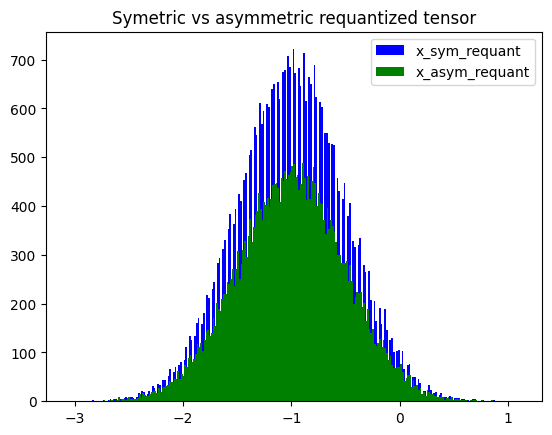

In [ ]:
x_sym_requant = s_sym*(x_int)
x_asym_requant = s_asym*(x_int_asym-z_int)
print(len(x_asym_requant), len(x_sym_requant))

plt.title(label="Symetric vs asymmetric requantized tensor")
plt.hist(x_sym_requant, bins=pow(2,M), label="x_sym_requant", color= ['blue'])
plt.hist(x_asym_requant, bins=pow(2,M), label="x_asym_requant", color= ['green'])


plt.legend()
plt.show()

Show error for each scheme

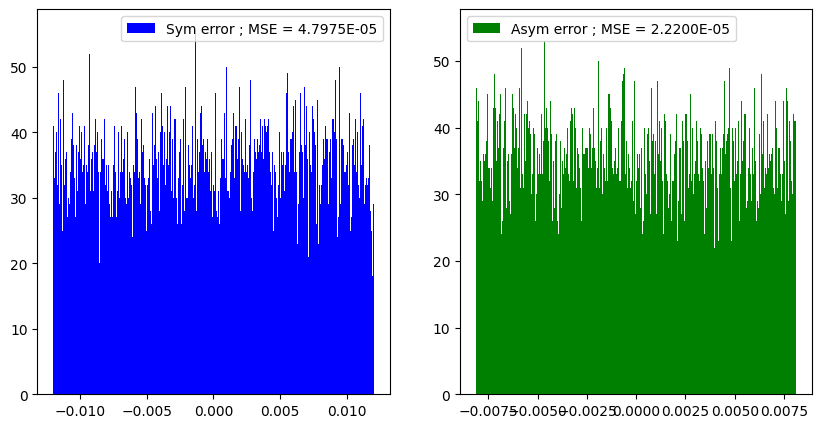

In [ ]:
MSE_sym = ((x_sym_requant - x_float)**2).mean()
MSE_asym = ((x_asym_requant - x_float)**2).mean()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(x_sym_requant - x_float, label=f"Sym error ; MSE = {MSE_sym:.4E}", bins=1000, color= ['blue'])
axs[0].legend()
axs[1].hist(x_asym_requant - x_float, label=f"Asym error ; MSE = {MSE_asym:.4E}", bins=1000, color= ['green'])
axs[1].legend()
plt.show()

Show error for each scheme on the same histogram

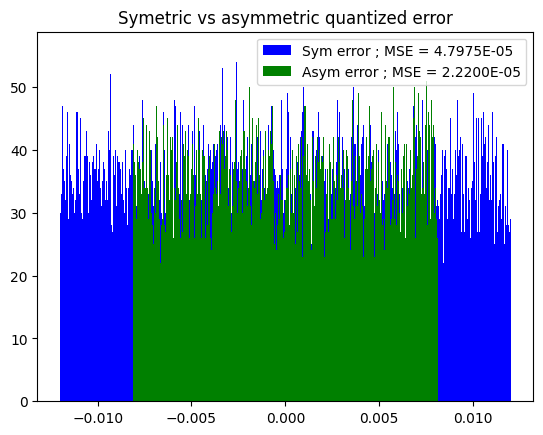

In [ ]:

plt.title(label="Symetric vs asymmetric quantized error")
plt.hist(x_sym_requant - x_float, bins=1000, label=f"Sym error ; MSE = {MSE_sym:.4E}", color= ['blue'])

plt.hist(x_asym_requant - x_float, bins=1000, label=f"Asym error ; MSE = {MSE_asym:.4E}", color= ['green'])

plt.legend()
plt.show()

# Compare symmetric and asymmetric

Fake symmetric quantization function

In [ ]:
def fake_sym_quant(x_float, M=8):
    a_min  = - pow(2,M-1)
    a_max  = pow(2,M-1) - 1

    f_max  = np.max(np.abs(x_float))

    s_sym = (f_max)/(a_max)

    x_int = np.clip(np.round(x_float/s_sym), a_min, a_max)

    x_sym_requant = s_sym*(x_int)

    return x_sym_requant

Fake asymmetric quantization function

In [ ]:
def fake_asym_quant(x_float, M=8):
    a_min  = - pow(2,M-1)
    a_max  = pow(2,M-1) - 1

    f_max_asym  = np.max(x_float)
    f_min_asym = np.min(x_float)

    s_asym = (f_max_asym - f_min_asym)/(a_max - a_min)

    z_int = - round(f_min_asym/s_asym) + a_min

    x_int_asym = np.clip(np.round(x_float/s_asym)+z_int, a_min, a_max)

    x_asym_requant = s_asym*(x_int_asym-z_int)

    return x_asym_requant

Compare for mu range (-mu_r,mu_r)

for mu = -10 ; MSE : sym > 7.79E-04 asym > 2.46E-05 ; sym - asym = 7.55E-04
for mu = -9 ; MSE : sym > 6.26E-04 asym > 2.20E-05 ; sym - asym = 6.04E-04
for mu = -8 ; MSE : sym > 5.27E-04 asym > 2.21E-05 ; sym - asym = 5.05E-04
for mu = -7 ; MSE : sym > 4.51E-04 asym > 2.28E-05 ; sym - asym = 4.28E-04
for mu = -6 ; MSE : sym > 3.22E-04 asym > 1.99E-05 ; sym - asym = 3.02E-04
for mu = -5 ; MSE : sym > 2.48E-04 asym > 1.88E-05 ; sym - asym = 2.29E-04
for mu = -4 ; MSE : sym > 1.94E-04 asym > 2.11E-05 ; sym - asym = 1.73E-04
for mu = -3 ; MSE : sym > 1.35E-04 asym > 2.25E-05 ; sym - asym = 1.13E-04
for mu = -2 ; MSE : sym > 8.10E-05 asym > 2.03E-05 ; sym - asym = 6.06E-05
for mu = -1 ; MSE : sym > 4.56E-05 asym > 2.03E-05 ; sym - asym = 2.53E-05
for mu = 0 ; MSE : sym > 2.12E-05 asym > 2.08E-05 ; sym - asym = 4.02E-07
for mu = 1 ; MSE : sym > 4.90E-05 asym > 2.10E-05 ; sym - asym = 2.80E-05
for mu = 2 ; MSE : sym > 8.46E-05 asym > 2.35E-05 ; sym - asym = 6.11E-05
for mu = 3 ; MSE : sym > 1.

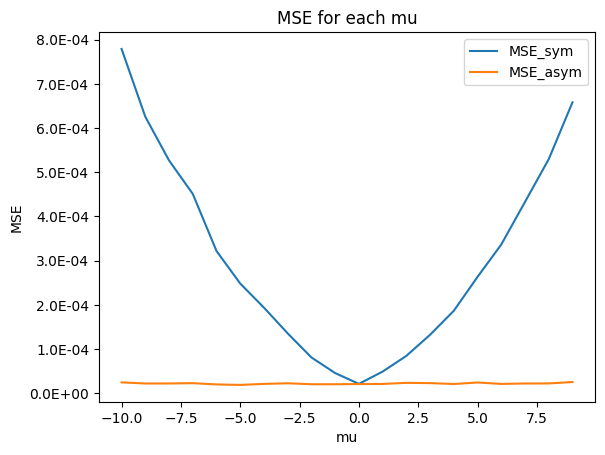

In [ ]:
# Normal distribution parameters
M = 8
sigma = 0.5
param = 35648
mu_r = 10

mu_range = np.array(range(-mu_r,mu_r))
MSE_sym = []
MSE_asym = []

for mu in mu_range :
    x_tensor = np.random.normal(mu, sigma, param)
    x_sym_requant = fake_sym_quant(x_tensor, M)
    MSE_sym.append(((x_sym_requant - x_tensor)**2).mean())
    x_asym_requant = fake_asym_quant(x_tensor, M)
    MSE_asym.append(((x_asym_requant - x_tensor)**2).mean())

for i, mu in enumerate(mu_range) :
    print(f"for mu = {mu} ; MSE : sym > {MSE_sym[i]:.2E} asym > {MSE_asym[i]:.2E} ; sym - asym = {(MSE_sym[i]-MSE_asym[i]):.2E}")
plt.title("MSE for each mu")
plt.plot(mu_range, MSE_sym, label = "MSE_sym")
plt.plot(mu_range, MSE_asym, label = "MSE_asym")
plt.xlabel("mu")
plt.ylabel("MSE")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1E}')) # 2 decimal places
plt.legend()
plt.show()